# Fine-Tuning a Generative Pretrained Transformer (`GPT`)

1. Install required libraries.

In [ ]:
!pip install transformers
!pip install codecarbon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 107.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.1/174.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.5 MB/s eta 0:00:00


2. Load the data from the hub.

In [ ]:
import pandas as pd
from datasets import load_dataset

dataset = load_dataset("nicholasKluge/fine-tuning-instruct-aira", split="aira_instruct_english")

df = dataset.to_pandas()

display(df)

prompt  \
0               Which is a species of fish? Tope or Rope   
1         Why can camels survive for long without water?   
2      Alice's parents have three daughters: Amy, Jes...   
3       Who gave the UN the land in NY to build their HQ   
4                            Why mobile is bad for human   
...                                                  ...   
53129  How do computers communicate and network with ...   
53130  How are websites different from web applications?   
53131     What is open-source software and its benefits?   
53132  What is a cookie and how is it used in web bro...   
53133  What is cloud storage and its advantages for d...   

                                              completion  
0                                                   Tope  
1      Camels use the fat in their humps to keep them...  
2                The name of the third daughter is Alice  
3                                    John D Rockerfeller  
4      We are always engaged one phone which is not g...  
...                                                  ...  
53129  Computers communicate and network with each ot...  
53130  Websites and web applications are similar in t...  
53131  Open-source software is software that is made ...  
53132  A cookie is a small piece of data that a websi...  
53133  Cloud storage is a service that allows you to ...  

[53134 rows x 2 columns]

3. Load `GPT2Tokenizer` and add the chosen special tokens (`'<|startoftext|>', '<|endoftext|>','<|pad|>'`)
4. Create demonstrations by prepending the special tokens.
5. Calculate the maximum length (in tokens) that the demonstrations have (the dataset was constructed, for efficiency and fast training, to be below the 300-token range).

In [ ]:
from transformers import GPT2Tokenizer

model = "gpt2-medium" # "gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "pierreguillou/gpt2-small-portuguese"
model_size = "355M" # "124M", "355M", "774M", and "1.5B", "PT-124M"

tokenizer = GPT2Tokenizer.from_pretrained(model,
                                          bos_token='<|startoftext|>',
                                          eos_token='<|endoftext|>',
                                          pad_token='<|pad|>')

df['demonstrations'] = tokenizer.bos_token + df['prompt'] + tokenizer.eos_token + df['completion'] + tokenizer.eos_token

df['length'] = df['demonstrations'].apply(lambda x: len(tokenizer.encode(x)))

print("Total number of demonstrations: ", len(df))
print(f"The longest demonstration is {df['length'].max()} tokens long.")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Total number of demonstrations:  53134
The longest demonstration is 300 tokens long.


6. Create the Dataset class.

In [ ]:
import torch
from torch.utils.data import Dataset

max_length = 300

class DemoDataset(Dataset):

  def __init__(self, demonstrations, tokenizer, gpt2_type="gpt2", max_length=max_length):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for demo in demonstrations:

      encodings_dict = tokenizer(demo,
                                 truncation=True,
                                 max_length=max_length,
                                 padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

7. Split the data into training and validation splits.

In [ ]:
from torch.utils.data import random_split

dataset = DemoDataset(df.demonstrations.to_list(), tokenizer, max_length=max_length)

train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('Number of training samples: {:,}'.format(train_size))
print('Number of validation samples: {:,}'.format(val_size))

Number of training samples: 47,820
Number of validation samples: 5,314


8. Create the `DataLoaders` and specify the `batch_size`.

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

train_dataloader = DataLoader(
            train_dataset,
            sampler=RandomSampler(train_dataset),
            batch_size=20 # 32, 20, 8, 6
        )

# validation data loader doesn't need randomization
validation_dataloader=DataLoader(
            val_dataset,
            sampler=SequentialSampler(val_dataset),
            batch_size=20
        )

9. Load the base model (`GPT2LMHeadModel`).

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Config

configuration = GPT2Config.from_pretrained(model, output_hidden_states=False)

model = GPT2LMHeadModel.from_pretrained(model, config=configuration)
model.resize_token_embeddings(len(tokenizer))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50259, bias=False)
)

10. Freeze some of the layers for constrained fine-tuning. This allows the model to retain some of its original capabilities after the tuning.

In [ ]:
UNFREEZE_LAST_N = 8 #6, 8, 12, 12

print("Number of transformer blocks in the model: ", model.config.n_layer)
print("Number of transformer blocks to  un-freeze: ", UNFREEZE_LAST_N)

for parameter in model.parameters():
    parameter.requires_grad = False

for i, m in enumerate(model.transformer.h):
    #Only un-freeze the last n transformer blocks
    if i+1 > model.config.n_layer - UNFREEZE_LAST_N:
        for parameter in m.parameters():
            parameter.requires_grad = True

        for parameter in model.transformer.ln_f.parameters():
            parameter.requires_grad = True

        for parameter in model.lm_head.parameters():
            parameter.requires_grad = True

num_frozen_layers = sum(1 for parameter in model.parameters() if not parameter.requires_grad)
num_trainable_layers = sum(1 for parameter in model.parameters() if parameter.requires_grad)

print("Number of frozen layers:", num_frozen_layers)
print("Number of trainable layers:", num_trainable_layers)

Number of transformer blocks in the model:  24
Number of transformer blocks to  un-freeze:  8
Number of frozen layers: 193
Number of trainable layers: 99


11. Set the training hyperparameters.

In [ ]:
from transformers import get_linear_schedule_with_warmup

# training rounds
epochs = 3 # 5, 3, 2, 1

# steps at the start of training that are ignored
warmup_steps = 1e2

# sample the model to test the output
sample_every = 300

optimizer = torch.optim.AdamW(model.parameters(), lr = 5e-4, eps = 1e-8)

# total steps = number of batches * number of epochs
total_steps = len(train_dataloader) * epochs

# create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

12. Training/Validation loop. Track the carbon emissions of your work by using `codecarbon`. 🌱

In [ ]:
from codecarbon import EmissionsTracker
import tqdm

output_dir = f'./Aira-{model_size}'

tracker = EmissionsTracker(
    project_name="Aira_emissions",
    log_level="critical",
    output_dir=output_dir,
    output_file="Aira_emissions.csv",
)

training_stats = []

tracker.start()
for epoch_i in range(0, epochs):

    print(f'\nBeginning epoch {epoch_i + 1} of {epochs}\n')

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(tqdm.tqdm(train_dataloader)):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(b_input_ids,
                        labels=b_labels,
                        attention_mask = b_masks,
                        token_type_ids=None)

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        if step % sample_every == 0 and not step == 0:

            print(f'\nBatch {step} of {len(train_dataloader)}. Loss:{batch_loss}.\n')

            model.eval()

            inputs = tokenizer(tokenizer.bos_token + df.prompt.sample().iloc[0] + tokenizer.eos_token, return_tensors="pt").to(device)

            sample_outputs = model.generate(**inputs,
                                bos_token_id=tokenizer.bos_token_id,
                                pad_token_id=tokenizer.pad_token_id,
                                eos_token_id=tokenizer.eos_token_id,
                                do_sample=True,
                                top_k=50,
                                max_length = 200,
                                top_p=0.95,
                                num_return_sequences=1)

            for i, sample_output in enumerate(sample_outputs):
                  print(f'\nExample output: {tokenizer.decode(sample_output, skip_special_tokens=True)}\n')

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)


    print(f'\nAverage Training Loss: {avg_train_loss}.\n')

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
                             attention_mask = b_masks,
                             labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)


    print(f'\nValidation loss: {avg_val_loss}.\n')

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
        }
    )

tracker.stop()
print("Training complete!")

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats.to_parquet(f"{output_dir}/training_stats.parquet", compression="gzip")

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Beginning epoch 1 of 3


 13%|█▎        | 300/2391 [04:13<29:02,  1.20it/s]

Batch 300 of 2391. Loss:0.8311468958854675.
Example output: I want to learn mathematics from a beginner level. Where should I begin.There are plenty of mathematics problems that you may not have the time or resources to solve. Take a look at the following list of questions:

10

1. What is a polynomial?

2. What is a trigonomial?
3. What is an eigendecid?

4. What is the real square?

5. What is a logarithmic square?


 25%|██▌       | 600/2391 [08:26<24:52,  1.20it/s]

Batch 600 of 2391. Loss:0.6423898935317993.
Example output: How many years have passed since you were born?The age of the world has ended with the rise of AI, machine learning, and data-driven decision making. These advancements have allowed us to navigate a new era of abundance in which we no longer possess ownership over the resources we have allocated to life and are instead reliant on machines to provide us with the most efficient and cost-effective solutions.

While the technology behind these transformations remains uncertain, there are a few promising trends that point in the direction of AI's ability to revolutionize our daily lives. These trends include advances in machine learning, personalized healthcare and finance, and augmented and virtual reality.


 38%|███▊      | 900/2391 [12:40<20:42,  1.20it/s]

Batch 900 of 2391. Loss:0.7947258949279785.
Example output: How can I learn a new language online.Start by familiarizing yourself with the basics of the language. Understand that there are several popular online language learning apps available, such as Duolingo, edX, or edX China. Be sure to take a course or practice a native language regularly before you go to an online language school. 

2. Read, write, and study the language

Practice speaking the language regularly and engaging in conversations with native speakers. Encourage native speakers to teach and explain to you, even when they don't understand your grammar or pronunciation. Additionally, use language learning apps to practice speaking the language and to learn slang and slang terms.

3. Learn pronunciation

Learn to read and write the language by reading, listening, and speaking with native speakers. Talk to a native speaker over the phone to get a sense of what they are saying. Listen to native speakers during classes or 

 50%|█████     | 1200/2391 [16:56<16:33,  1.20it/s]

Batch 1200 of 2391. Loss:0.6887515783309937.
Example output: What are the benefits of living by a lake.The benefits of living by a lake include improved hydration levels and increased immunity, increased energy levels, and improved mental health.


 63%|██████▎   | 1500/2391 [21:07<12:22,  1.20it/s]

Batch 1500 of 2391. Loss:0.557076096534729.
Example output: What kind of fertilizer is best for a vegetable garden.The best fertilizer for a vegetable garden depends on the variety and size of the plants. Composted compost materials can be a great choice for vegetable garden fertilizers, as they contain less greenhouse gases than their raw counterparts. Composted fertilizers are also more environmentally friendly as they are usually biodegradable and provide better nutrient levels for your garden. Additionally, compost is often used to fill in natural gaps in compost piles.


 75%|███████▌  | 1800/2391 [25:19<08:12,  1.20it/s]

Batch 1800 of 2391. Loss:0.7273032665252686.
Example output: What is the most popular spaghetti dish in Italy.The most popular dish in Italy is spaghetti with pesto.


 88%|████████▊ | 2100/2391 [29:30<04:02,  1.20it/s]

Batch 2100 of 2391. Loss:0.7546969652175903.
Example output: How can I make a healthy breakfast that takes less than 10 minutes to make.To make a healthy breakfast, start by gathering the ingredients you'll need: eggs, fruit, yogurt, nuts, avocados, peanut butter, and syrup. Heat a non-stick pan over medium-high heat and add your eggs, then your fruit, yogurt, and peanut butter. Allow the pan to cook for a few minutes before adding your peanut butter and any other ingredients. Flip the eggs every so often and cook until they are completely set. Serve with a side of boiled egg or toast.


100%|██████████| 2391/2391 [33:35<00:00,  1.19it/s]


Average Training Loss: 0.8037641328879851.
Validation loss: 0.6114786967523116.
Beginning epoch 2 of 3


 13%|█▎        | 300/2391 [04:10<29:02,  1.20it/s]

Batch 300 of 2391. Loss:0.5744898319244385.
Example output: Create a Python script to find the sum of all numbers ranging from k to n inclusive.Sum: k + n + k
      + n + k


 25%|██▌       | 600/2391 [08:20<24:56,  1.20it/s]

Batch 600 of 2391. Loss:0.6873356103897095.
Example output: What criticisms have been made of updateless decision theory?UDT is a decision theory system with two fundamental pillars: an agent theory and an RNN. UDT's decision trees allow for seamless decision-making, which is a crucial aspect in current state-of-the-art UDT-based decision-making systems. UDT is Turing complete and offers a wide range of decision-making options for different tasks, such as monitoring a customer’s purchases, playing chess, or investing in stocks and bonds. For more details, refer to "Updateless Decision Theory: A Review of 200 Guidelines and Recommendations for a New Decision Theory."


 38%|███▊      | 900/2391 [12:34<20:42,  1.20it/s]

Batch 900 of 2391. Loss:0.5231805443763733.
Example output: Does the Earth revolve around the moon.Yes, the Earth revolved around the moon millions of years ago.


 50%|█████     | 1200/2391 [16:44<16:32,  1.20it/s]

Batch 1200 of 2391. Loss:0.49868226051330566.
Example output: What do you mean by sustainable AI?Sustainability refers to AI technology being developed that is non-polluting, energy efficient, and uses limited resources.


 63%|██████▎   | 1500/2391 [20:55<12:22,  1.20it/s]

Batch 1500 of 2391. Loss:0.6849273443222046.
Example output: How do I make the best cup of coffee.To make the best cup of coffee, start by choosing a cup that is light, steaming, and has a good burr. Once the burr is set, heat the water to about 400°F. Pour the coffee into the cup and let the brew for a few minutes before pouring the rest of the coffee into the cup. Finally, top the cup off with your favorite toppings and enjoy.


 75%|███████▌  | 1800/2391 [25:08<08:12,  1.20it/s]

Batch 1800 of 2391. Loss:0.7784386277198792.
Example output: Where can I find low-cost flights to Alaska.You can find low-cost flights to Alaska by searching on airline websites such as Expedia, Skyscanner, and Kayak. You can also search directly for flights online using airline search engines, such as Google Flights.


 88%|████████▊ | 2100/2391 [29:19<04:02,  1.20it/s]

Batch 2100 of 2391. Loss:0.7476993799209595.
Example output: What are the benefits of using renewable energy sources.The benefits of using renewable energy sources include reducing dependence on finite resources, reducing the need for large-scale fossil fuels, providing access to renewable energy resources and reducing carbon emissions from the energy sector. Additionally, renewable energy sources can provide a way for people to reduce their reliance on fossil fuels by transitioning to renewable energy sources such as solar, wind, and hydro power.


100%|██████████| 2391/2391 [33:24<00:00,  1.19it/s]


Average Training Loss: 0.5702004936986865.
Validation loss: 0.5858413227518698.
Beginning epoch 3 of 3


 13%|█▎        | 300/2391 [04:10<29:03,  1.20it/s]

Batch 300 of 2391. Loss:0.4317343533039093.
Example output: I'm concerned about my finances and want to develop a budget. Can you help.I'm sorry, I'm not a financial expert, but I can help you identify how much money you have available to save and what savings strategies you may be able to implement to help you achieve your financial goals. It can be helpful to review the budget periodically and be sure to stay on track. Additionally, consider talking to a financial consultant who can provide guidance to help make the process smoother.


 25%|██▌       | 600/2391 [08:22<24:51,  1.20it/s]

Batch 600 of 2391. Loss:0.3909016251564026.
Example output: What is the significance of the "p versus np" problem?A problem is defined as a problem that can be solved in a number of steps bounded by a polynomial function of n, where n corresponds to the power of the input length, for example, a problem of algorithm complexity is restricted by a polynomial function of n. Although NP is the formal name of decision theory, it has a simpler and more concise definition than other complexity classes such as linear or quadratic, due to the fact that all problems solvable by any algorithm can also be solved.


 38%|███▊      | 900/2391 [12:35<20:43,  1.20it/s]

Batch 900 of 2391. Loss:0.3943908214569092.
Example output: How big of a storage tank do I need to store 1,000 gallons of water.To store 1,000 gallons of water, you will need a storage tank or other water-saving method. You will also need to purchase water supplies such as a rain barrel, faucet, showerhead, or other water filtration system. You will also need to install a dishwasher, dish washing machine, and washing machine.


 50%|█████     | 1200/2391 [16:47<16:32,  1.20it/s]

Batch 1200 of 2391. Loss:0.5626760721206665.
Example output: I need help with understanding a specific math problem.The best way to understand a math problem is to break it down into smaller parts and study each one step-by-step. Identify the steps that need to be taken to solve the problem and then work backward to identify the best way to solve them. After you have an understanding of the problem, you can then work to make sure that the solution is correct.


 63%|██████▎   | 1500/2391 [20:59<12:22,  1.20it/s]

Batch 1500 of 2391. Loss:0.6661339998245239.
Example output: What are the three main types of clouds.The three main types of clouds are cumulus, cumulonimbus, and polygon.


 75%|███████▌  | 1800/2391 [25:10<08:13,  1.20it/s]

Batch 1800 of 2391. Loss:0.5321910381317139.
Example output: What is the best way to clean a wool sweater.The best way to clean a wool sweater is to use a mild detergent and warm water, spot clean and condition the sweater with a mild detergent and warm water, then launder the sweater according to the care instructions on the care label. Rinse the garment in clean water and dry thoroughly before hanging it up.


 88%|████████▊ | 2100/2391 [29:22<04:02,  1.20it/s]

Batch 2100 of 2391. Loss:0.4964297413825989.
Example output: Give me an idea of the mental exercises you do to inspire yourself.
 Input: - Exercise regularly
- Take breaks
- Set realistic goals
- Connect with friends
- Engage with nature
- Limit distractions
- Participate in activities you enjoy
- Talk to others
- Set realistic expectations
- Take a break to focus on a specific task
- Write down your thoughts
- Use positive affirmations
- Read more about it.


100%|██████████| 2391/2391 [33:27<00:00,  1.19it/s]


Average Training Loss: 0.4873914483300516.
Validation loss: 0.5831270120421747.
Training complete!


13. Check the training stats and plot the learning curves.

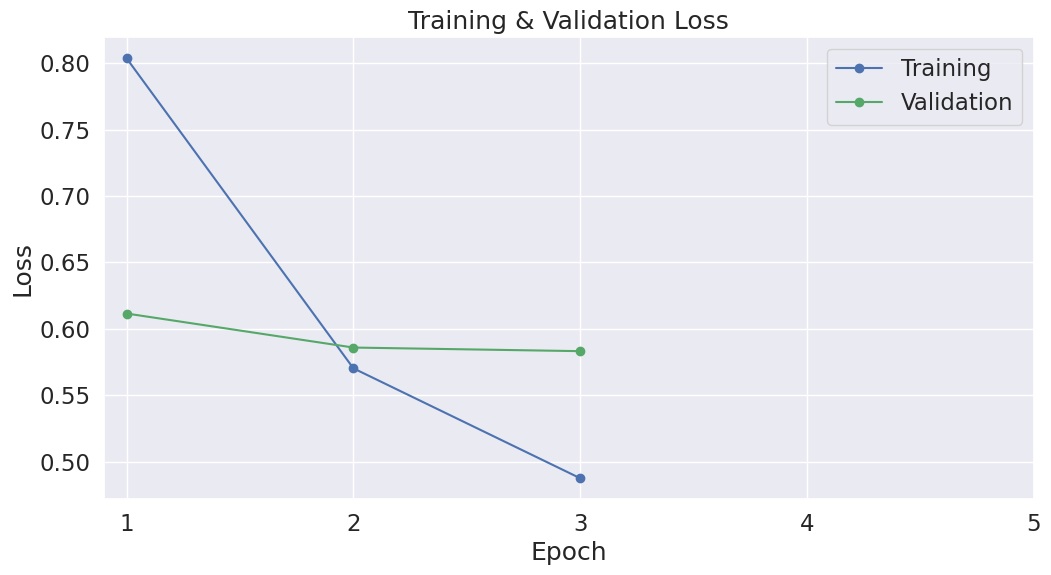

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df_stats = pd.read_parquet(f"{output_dir}/training_stats.parquet")

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4, 5])

plt.show()

13. Load and test the model.

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda"  if torch.cuda.is_available() else  "cpu")

tokenizer = AutoTokenizer.from_pretrained(output_dir)
aira = AutoModelForCausalLM.from_pretrained(output_dir)

aira.eval()
aira.to(device)

question =  input("Enter your question: ")

inputs = tokenizer(tokenizer.bos_token + question + tokenizer.eos_token, return_tensors="pt").to(device)

responses = aira.generate(**inputs,
    bos_token_id=tokenizer.bos_token_id,
    pad_token_id=tokenizer.pad_token_id,
    eos_token_id=tokenizer.eos_token_id,
    do_sample=True,
    top_k=50,
    max_length=200,
    top_p=0.95,
    temperature=0.7,
    num_return_sequences=2)

print(f"Question: 👤 {question}\n")

for i, response in  enumerate(responses):
    # print only the response and remove the question
    print(f'Response {i+1}: 🤖 {tokenizer.decode(response, skip_special_tokens=True).replace(question, "")}')


Done! 🤗